# 9. Automated Machine Learning 

This notebook contains some basics for autoML using CapyMOA
* Test example of autoML
* How to use CapyMOA for autoML
---

### Build your own pipeline
Either you will create you own autoML solution or use existing autoML ones, you need to undrestand the data and the pipeline that you are going to create/use 
* Data preprocessing
* Feature preprocessing
* Select the method(s) that will be used and train the model(s)
* If you are creating your automated method, choose the hyperparameter optimization method to use

### Model Selection
Select the best performing model among four state-of-the-art online learning models (HT, KNN, ARF, SRP, NB) by evaluating their learning performance
* We used a set of heterogeneous classifiers (using their default configuration) and select the best performing one based on their accuracies
* Todo so, we implemented `stream_learning_model_selection`

In [1]:
from capymoa.datasets import Electricity
from capymoa.evaluation import prequential_evaluation
from moa.streams import ConceptDriftStream
from capymoa.stream.drift import DriftStream
from capymoa.evaluation.visualization import plot_windowed_results
from capymoa.classifier import (
    HoeffdingTree,  
    HoeffdingAdaptiveTree,
    KNN,
    NaiveBayes,
    AdaptiveRandomForestClassifier, 
    StreamingRandomPatches
)
streaming_dataset = Electricity()
streaming_dataset_drift = DriftStream(moa_stream=ConceptDriftStream(), 
                               CLI='-s (generators.AgrawalGenerator -f 1) -d (ConceptDriftStream -s (generators.AgrawalGenerator -f 2) -d (ConceptDriftStream -s (generators.AgrawalGenerator -f 3) -d (generators.AgrawalGenerator -f 4) -p 30000 -w 0) -p 20000 -w 0) -p 10000 -w 0')

In [2]:
# Define a generic adaptive learning function
def stream_learning_model_selection(model_list, window_size, max_instances):
    acc_b = 0 # The best accuracy score
    all_results = {}
    for model in model_list:
        results = prequential_evaluation(
            stream=streaming_dataset,
            learner=model,
            window_size=window_size,
            max_instances=max_instances
        )
        all_results[model] = results
        if results.cumulative.accuracy()>acc_b:
            acc_b = results.cumulative.accuracy()
            model_b = model
            
    print(f"{model_b} is selected as the best learner as it has the highest accuracy of: {results.cumulative.accuracy()} and wallclock: {results.wallclock()}")  
    return all_results

StreamingRandomPatches is selected as the best learner as it has the highest accuracy of: 80.44 and wallclock: 0.060131072998046875


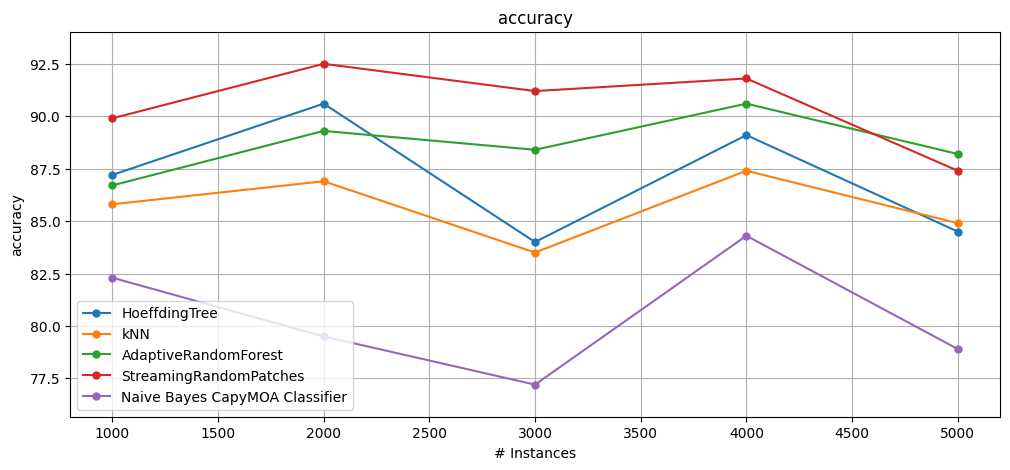

In [3]:
# Code to select the best performing model
ht = HoeffdingTree(schema=streaming_dataset.get_schema())
knn = KNN(schema=streaming_dataset.get_schema())
arf = AdaptiveRandomForestClassifier(schema=streaming_dataset.get_schema(), ensemble_size=5)
srp = StreamingRandomPatches(schema=streaming_dataset.get_schema(), ensemble_size=5)
nb = NaiveBayes(schema=streaming_dataset.get_schema())

model_list = [ht, knn, arf, srp, nb]

all_res = stream_learning_model_selection(model_list, 1000, 5000) 

plot_windowed_results(*all_res.values(), metric='accuracy')

## AutoML for Data streams
### Model selection and HPO

The following example shows how to use the AutoClass algorithm using CapyMOA. 
* The current version of AutoClass is configured using a json configuration file `configuration_json` and a list of classifiers `base_classifiers`
* The `configuration_json` is updatable, i.e., algorithms and their hyperparameter configurations can be changed
* AutoClass can also be configured with either a list of strings `base_classifiers` representing the MOA classifiers. This approach is only enticing for people that are very familiar with MOA. 
* In the example below, we also compare it against using the base classifiers individually


[HT] Cumulative accuracy = 85.615, wall-clock time: 0.07500076293945312
[HAT] Cumulative accuracy = 87.075, wall-clock time: 0.19931817054748535
[KNN] Cumulative accuracy = 85.47, wall-clock time: 0.9464659690856934
[NB] Cumulative accuracy = 77.235, wall-clock time: 0.0331571102142334
[AutoClass] Cumulative accuracy = 88.225, wall-clock time: 16.31660509109497


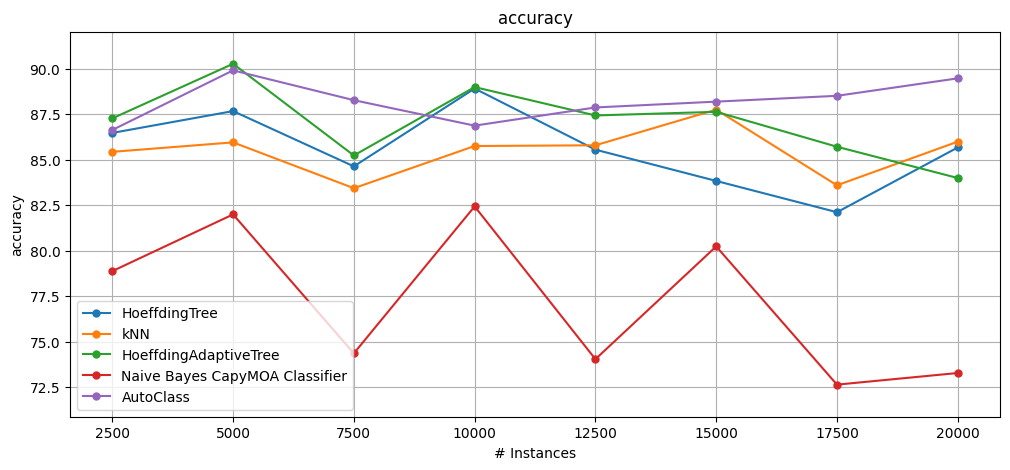

In [4]:
from capymoa.evaluation import prequential_evaluation 
from capymoa.automl import AutoClass

max_instances = 20000
window_size = 2500

ht = HoeffdingTree(schema=streaming_dataset.get_schema())
hat = HoeffdingAdaptiveTree(schema=streaming_dataset.get_schema())
knn = KNN(schema=streaming_dataset.get_schema())
nb = NaiveBayes(schema=streaming_dataset.get_schema())
autoclass = AutoClass(schema=streaming_dataset.get_schema(), 
                      configuration_json='./settings_autoclass.json', 
                      base_classifiers=[KNN, HoeffdingAdaptiveTree, HoeffdingTree])

results_ht = prequential_evaluation(stream=streaming_dataset, learner=ht, window_size=window_size, max_instances=max_instances)
results_hat = prequential_evaluation(stream=streaming_dataset, learner=hat, window_size=window_size, max_instances=max_instances)
results_knn = prequential_evaluation(stream=streaming_dataset, learner=knn, window_size=window_size, max_instances=max_instances)
results_nb = prequential_evaluation(stream=streaming_dataset, learner=nb, window_size=window_size, max_instances=max_instances)
results_autoclass = prequential_evaluation(stream=streaming_dataset, learner=autoclass, window_size=window_size, max_instances=max_instances)

print(f"[HT] Cumulative accuracy = {results_ht.accuracy()}, wall-clock time: {results_ht.wallclock()}")
print(f"[HAT] Cumulative accuracy = {results_hat.accuracy()}, wall-clock time: {results_hat.wallclock()}")
print(f"[KNN] Cumulative accuracy = {results_knn.accuracy()}, wall-clock time: {results_knn.wallclock()}")
print(f"[NB] Cumulative accuracy = {results_nb.accuracy()}, wall-clock time: {results_nb.wallclock()}")
print(f"[AutoClass] Cumulative accuracy = {results_autoclass.accuracy()}, wall-clock time: {results_autoclass.wallclock()}")
plot_windowed_results(results_ht, results_knn, results_hat, results_nb, results_autoclass, metric='accuracy')

* We tested the same algorithms on the dataset with simulated drift `streaming_dataset_drift`

[HT] Cumulative accuracy = 78.82249999999999, wall-clock time: 0.19745421409606934
[HAT] Cumulative accuracy = 78.23750000000001, wall-clock time: 0.23102211952209473
[KNN] Cumulative accuracy = 67.14, wall-clock time: 2.7639410495758057
[NB] Cumulative accuracy = 60.29, wall-clock time: 0.06737995147705078
[AutoClass] Cumulative accuracy = 84.82499999999999, wall-clock time: 37.26948094367981


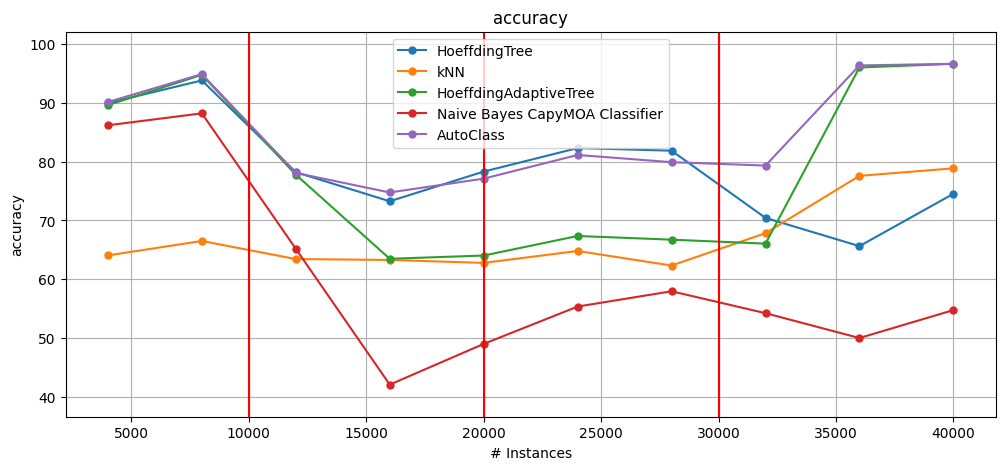

In [5]:
from capymoa.evaluation import prequential_evaluation 
from capymoa.automl import AutoClass

max_instances = 40000
window_size = 4000

ht = HoeffdingTree(schema=streaming_dataset_drift.get_schema())
hat = HoeffdingAdaptiveTree(schema=streaming_dataset_drift.get_schema())
knn = KNN(schema=streaming_dataset_drift.get_schema())
nb = NaiveBayes(schema=streaming_dataset_drift.get_schema())
autoclass = AutoClass(schema=streaming_dataset_drift.get_schema(), 
                      configuration_json='./settings_autoclass.json', 
                      base_classifiers=[KNN, HoeffdingAdaptiveTree, HoeffdingTree])

results_ht = prequential_evaluation(stream=streaming_dataset_drift, learner=ht, window_size=window_size, max_instances=max_instances)
results_hat = prequential_evaluation(stream=streaming_dataset_drift, learner=hat, window_size=window_size, max_instances=max_instances)
results_knn = prequential_evaluation(stream=streaming_dataset_drift, learner=knn, window_size=window_size, max_instances=max_instances)
results_nb = prequential_evaluation(stream=streaming_dataset_drift, learner=nb, window_size=window_size, max_instances=max_instances)
results_autoclass = prequential_evaluation(stream=streaming_dataset_drift, learner=autoclass, window_size=window_size, max_instances=max_instances)

print(f"[HT] Cumulative accuracy = {results_ht.accuracy()}, wall-clock time: {results_ht.wallclock()}")
print(f"[HAT] Cumulative accuracy = {results_hat.accuracy()}, wall-clock time: {results_hat.wallclock()}")
print(f"[KNN] Cumulative accuracy = {results_knn.accuracy()}, wall-clock time: {results_knn.wallclock()}")
print(f"[NB] Cumulative accuracy = {results_nb.accuracy()}, wall-clock time: {results_nb.wallclock()}")
print(f"[AutoClass] Cumulative accuracy = {results_autoclass.accuracy()}, wall-clock time: {results_autoclass.wallclock()}")
plot_windowed_results(results_ht, results_knn, results_hat, results_nb, results_autoclass, metric='accuracy')

### AutoML for everyone in 3 lines of code !! 

In [6]:
autoclass = AutoClass(schema=streaming_dataset_drift.get_schema(), 
                      configuration_json='./settings_autoclass.json', 
                      base_classifiers=[KNN, HoeffdingAdaptiveTree, HoeffdingTree])
results_autoclass = prequential_evaluation(stream=streaming_dataset, learner=autoclass, window_size=window_size, max_instances=max_instances)

print(f"[AutoClass] Cumulative accuracy = {results_autoclass.accuracy()}, wall-clock time: {results_autoclass.wallclock()}")

[AutoClass] Cumulative accuracy = 86.125, wall-clock time: 38.70991015434265
